In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 128
epochs = 20
learning_rate = 0.001
latent_dim = 2

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


def loss_function(recon_x, x, mu, logvar, use_recon=True, use_kld=True, use_mse=False):
    if use_recon:
        if use_mse:
            recon_loss = F.mse_loss(recon_x, x.view(-1, 28 * 28), reduction='sum')
        else:
            recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    else:
        recon_loss = torch.tensor(0.0).to(device)

    if use_kld:
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    else:
        kld_loss = torch.tensor(0.0).to(device)

    return recon_loss + kld_loss, recon_loss, kld_loss

def train(model, optimizer, epoch, use_recon=True, use_kld=True, use_mse=False):
    model.train()
    train_loss = 0
    recon_loss = 0
    kld_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon, kld = loss_function(recon_batch, data, mu, logvar, use_recon, use_kld, use_mse)
        loss.backward()
        train_loss += loss.item()
        recon_loss += recon.item()
        kld_loss += kld.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss / len(train_loader.dataset)
    avg_kld = kld_loss / len(train_loader.dataset)

    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f} = Recon: {avg_recon:.4f} + KLD: {avg_kld:.4f}')
    return avg_loss, avg_recon, avg_kld

def test(model, epoch, use_recon=True, use_kld=True, use_mse=False):
    model.eval()
    test_loss = 0
    recon_loss = 0
    kld_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, recon, kld = loss_function(recon_batch, data, mu, logvar, use_recon, use_kld, use_mse)
            test_loss += loss.item()
            recon_loss += recon.item()
            kld_loss += kld.item()

    avg_loss = test_loss / len(test_loader.dataset)
    avg_recon = recon_loss / len(test_loader.dataset)
    avg_kld = kld_loss / len(test_loader.dataset)

    print(f'====> Test set loss: {avg_loss:.4f} = Recon: {avg_recon:.4f} + KLD: {avg_kld:.4f}')
    return avg_loss, avg_recon, avg_kld

In [4]:
def visualize_latent_space(model, title):
    model.eval()
    data_loader = DataLoader(test_dataset, batch_size=2000, shuffle=False)
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            _, mu, _ = model(data)
            all_mu.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())

    all_mu = np.concatenate(all_mu, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    df = pd.DataFrame({
        'Latent Dim 1': all_mu[:, 0],
        'Latent Dim 2': all_mu[:, 1],
        'Label': all_labels
    })

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=df,
        x='Latent Dim 1',
        y='Latent Dim 2',
        hue='Label',
        palette='tab10',
        alpha=0.7,
        s=80
    )
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.close()

def visualize_reconstructions(model, title):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:8].to(device)
        recon_batch, _, _ = model(data)

        plt.figure(figsize=(12, 6))
        for i in range(8):
            plt.subplot(2, 8, i + 1)
            plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Original')

            plt.subplot(2, 8, i + 9)
            plt.imshow(recon_batch[i].cpu().view(28, 28).numpy(), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')

        plt.suptitle(title)
        plt.show()
        plt.close()

def visualize_gaussian_grid(model, title, grid_size=20, range_limit=3):
    model.eval()

    x = np.linspace(-range_limit, range_limit, grid_size)
    y = np.linspace(-range_limit, range_limit, grid_size)
    z_grid = np.zeros((grid_size * grid_size, 2))
    
    index = 0
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            z_grid[index, 0] = xi
            z_grid[index, 1] = yi
            index += 1
    
    z = torch.FloatTensor(z_grid).to(device)
    
    with torch.no_grad():
        generated = model.decode(z).cpu().view(-1, 28, 28).numpy()
    
    plt.figure(figsize=(15, 15))
    index = 0
    for i in range(grid_size):
        for j in range(grid_size):
            plt.subplot(grid_size, grid_size, index + 1)
            plt.imshow(generated[index], cmap='gray')
            plt.axis('off')
            index += 1
    
    plt.suptitle(title)
    plt.show()
    plt.close()


# 1. Standard VAE training with both BCE and KLD loss


Experiment: Standard VAE (BCE + KLD)
====> Epoch: 1 Average loss: 180.5545 = Recon: 176.3732 + KLD: 4.1813
====> Test set loss: 163.9346 = Recon: 158.7686 + KLD: 5.1660
====> Epoch: 2 Average loss: 159.3117 = Recon: 153.9346 + KLD: 5.3770
====> Test set loss: 156.0225 = Recon: 150.3541 + KLD: 5.6684
====> Epoch: 3 Average loss: 153.9922 = Recon: 148.2803 + KLD: 5.7118
====> Test set loss: 153.1667 = Recon: 147.6240 + KLD: 5.5427
====> Epoch: 4 Average loss: 150.8780 = Recon: 144.9667 + KLD: 5.9113
====> Test set loss: 150.0015 = Recon: 143.9907 + KLD: 6.0109
====> Epoch: 5 Average loss: 148.7198 = Recon: 142.6133 + KLD: 6.1065
====> Test set loss: 148.5031 = Recon: 142.4694 + KLD: 6.0338
====> Epoch: 6 Average loss: 147.0837 = Recon: 140.8763 + KLD: 6.2074
====> Test set loss: 146.6497 = Recon: 140.3780 + KLD: 6.2717
====> Epoch: 7 Average loss: 145.8940 = Recon: 139.5927 + KLD: 6.3013
====> Test set loss: 145.9770 = Recon: 139.6931 + KLD: 6.2839
====> Epoch: 8 Average loss: 144.9067 

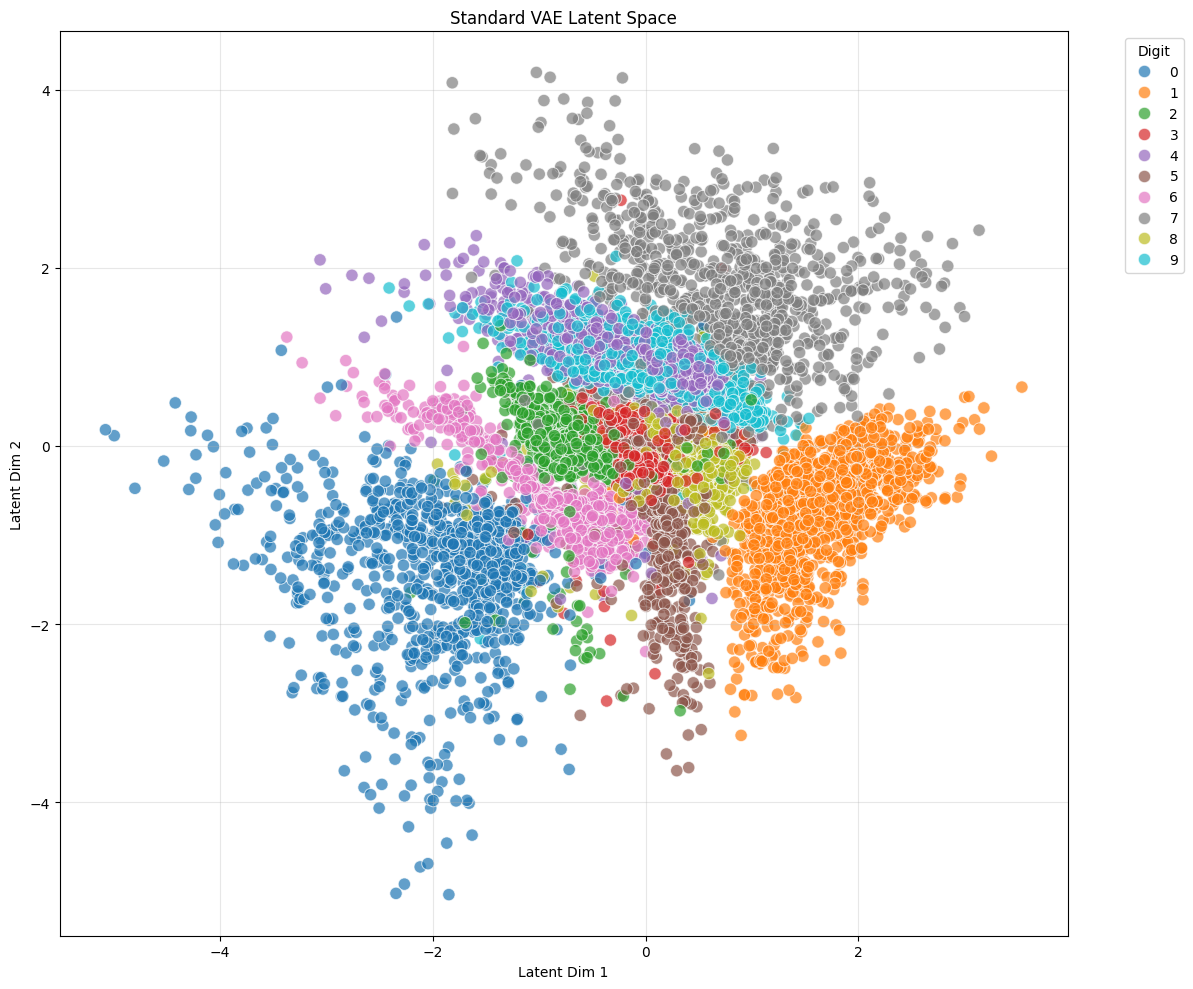

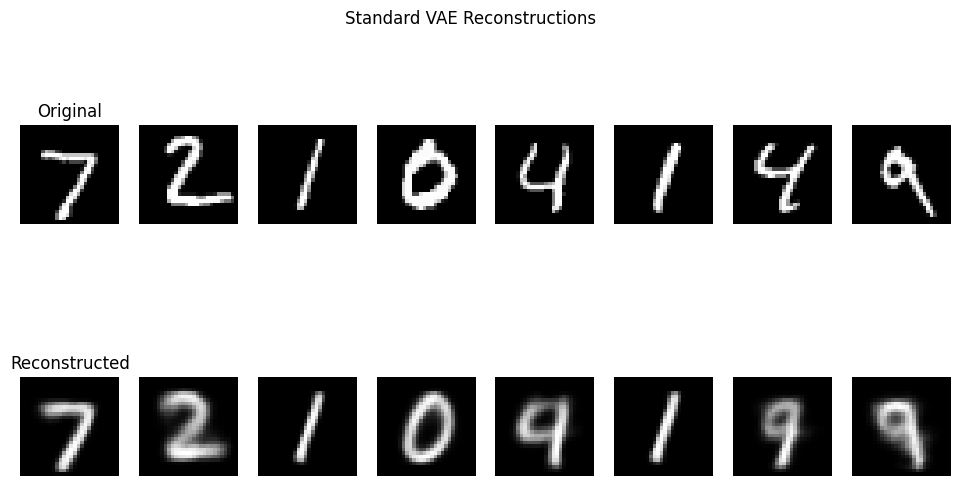

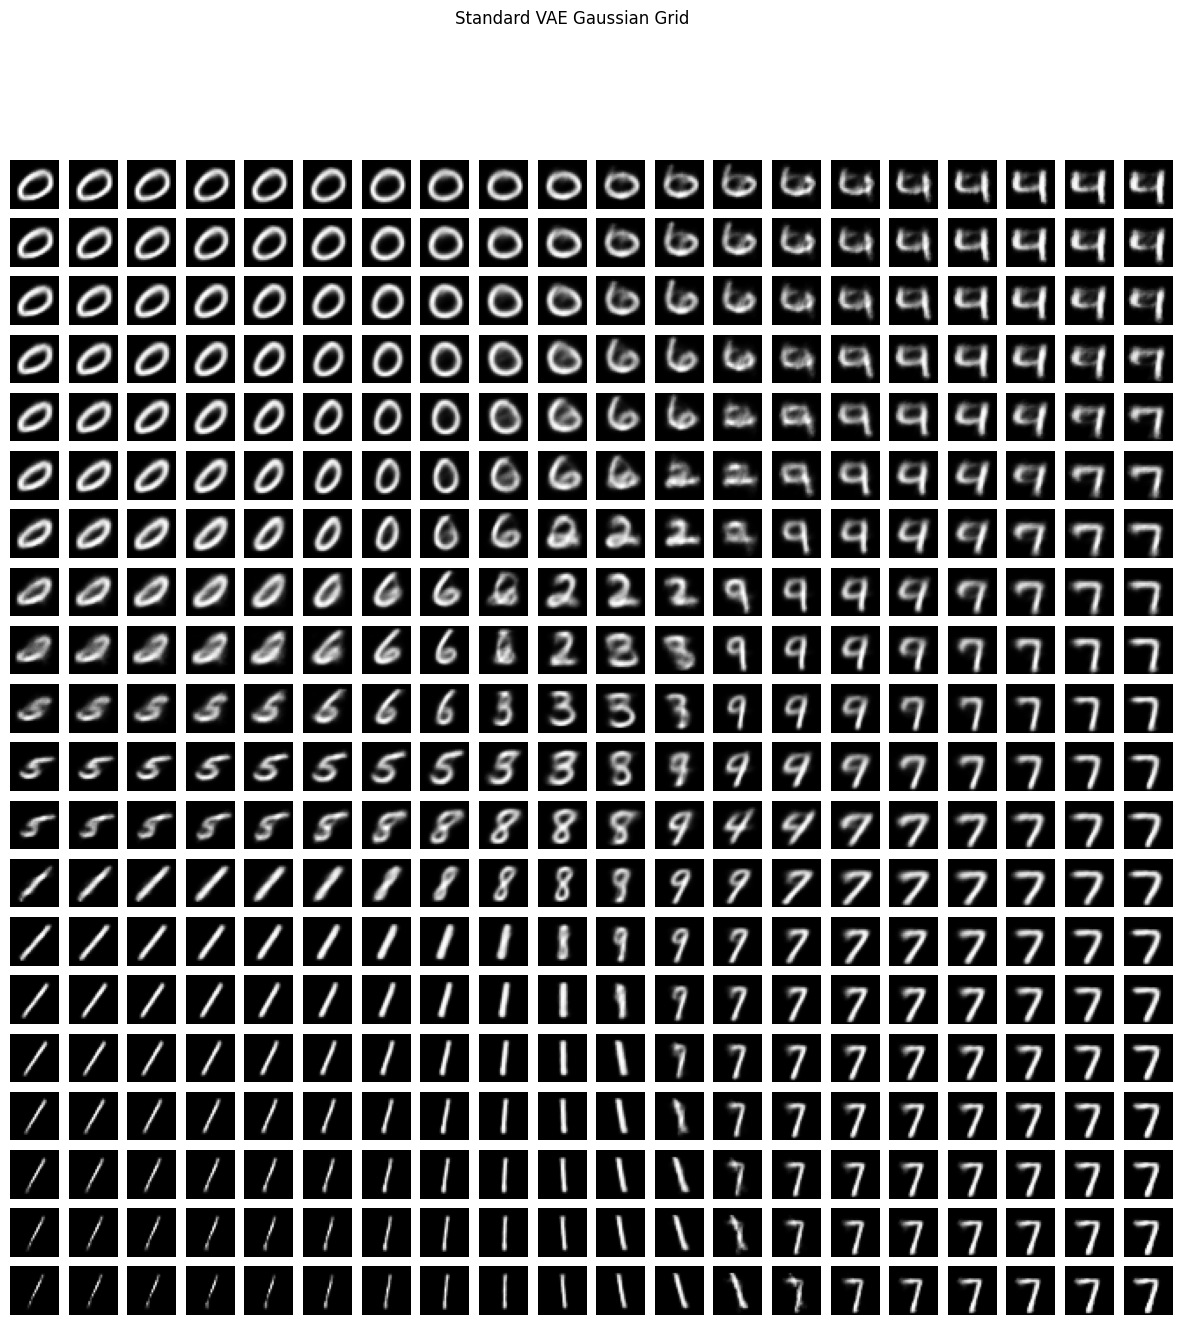

In [5]:
def experiment_standard_vae():
    print("\nExperiment: Standard VAE (BCE + KLD)")
    model = VAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        train_loss, train_recon, train_kld = train(model, optimizer, epoch, use_recon=True, use_kld=True)
        test_loss, test_recon, test_kld = test(model, epoch, use_recon=True, use_kld=True)
        train_losses.append((train_loss, train_recon, train_kld))
        test_losses.append((test_loss, test_recon, test_kld))

    visualize_latent_space(model, "Standard VAE Latent Space")
    visualize_reconstructions(model, "Standard VAE Reconstructions")
    visualize_gaussian_grid(model, "Standard VAE Gaussian Grid")
    return model

m=experiment_standard_vae()

### **Observations from VAE Gaussian Grid Sampling**

1. **Smooth Transition Between Digits**  
   - The generated digits change gradually across the grid, indicating that the **VAE has learned a meaningful latent space representation**.
   - This smooth interpolation suggests the latent space is continuous and well-structured.

2. **Clustered Digit Representations**  
   - Similar digits are grouped together in specific regions of the grid.
   - This shows that VAE encodes semantic similarities in the latent space.

3. **Blurry or Mixed Digits in Transition Zones**  
   - In regions where different digits meet, there are blurry or hybrid-like digits.
   - This occurs because the latent space tries to **blend features between nearby clusters**.

4. **Extreme Latent Values Lead to Unclear Digits**  
   - Towards the edges of the grid, the reconstructions become less distinct, suggesting that **the model has seen fewer examples** from these regions during training.


# 2. VAE without reconstruction loss (KLD only)


Experiment: VAE without Reconstruction Loss (KLD only)
====> Epoch: 1 Average loss: 0.0002 = Recon: 0.0000 + KLD: 0.0002
====> Test set loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Epoch: 2 Average loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Test set loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Epoch: 3 Average loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Test set loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Epoch: 4 Average loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Test set loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Epoch: 5 Average loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Test set loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Epoch: 6 Average loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Test set loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Epoch: 7 Average loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Test set loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Epoch: 8 Average loss: 0.0000 = Recon: 0.0000 + KLD: 0.0000
====> Test

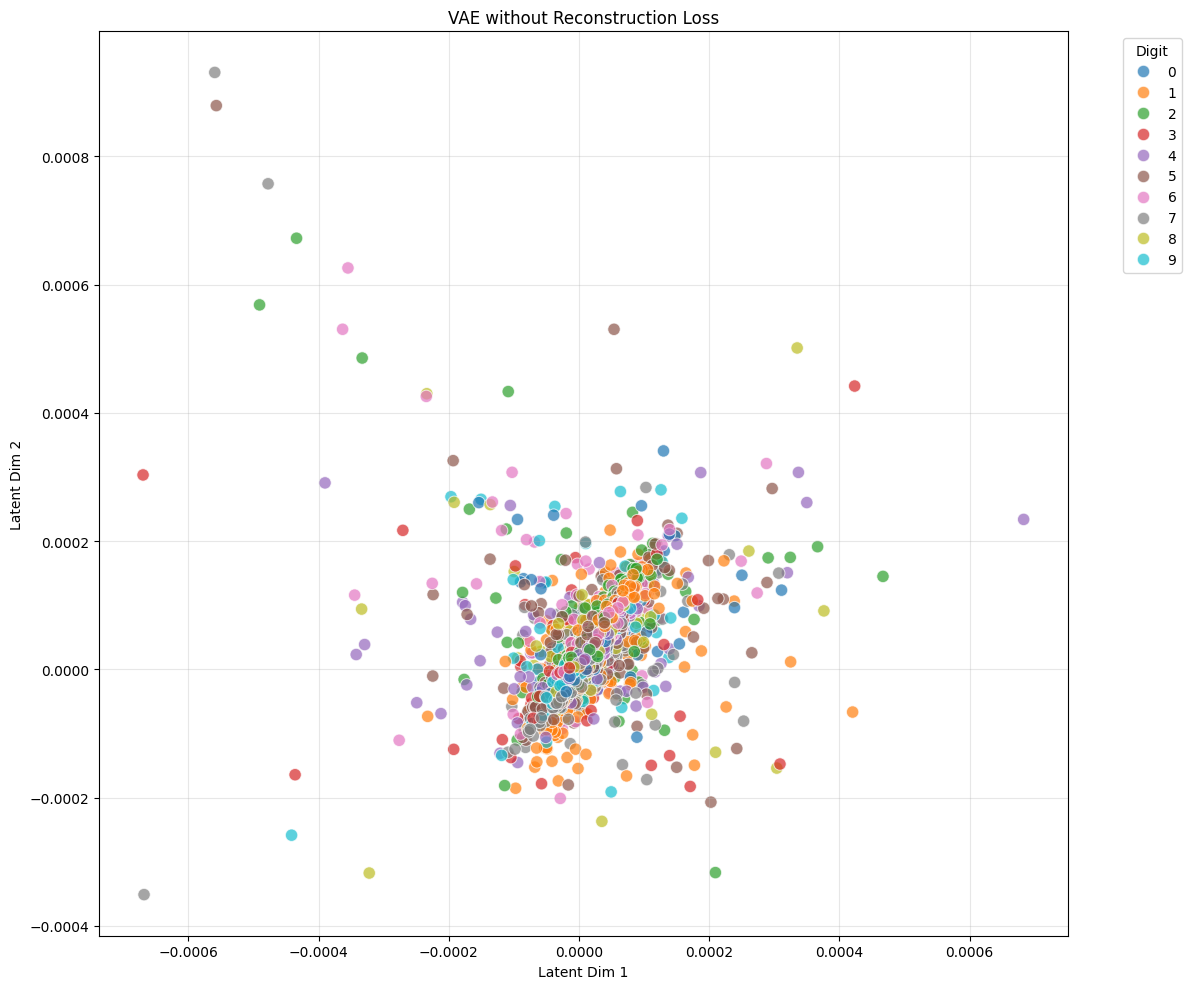

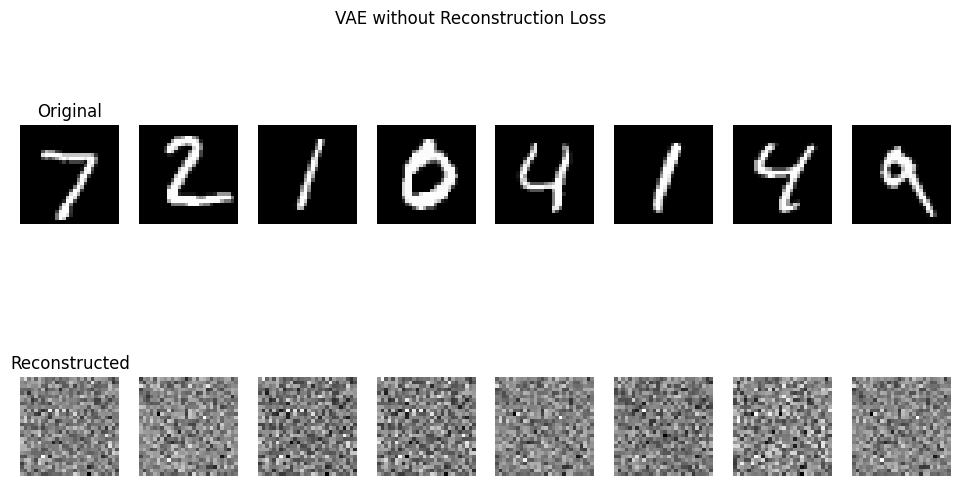

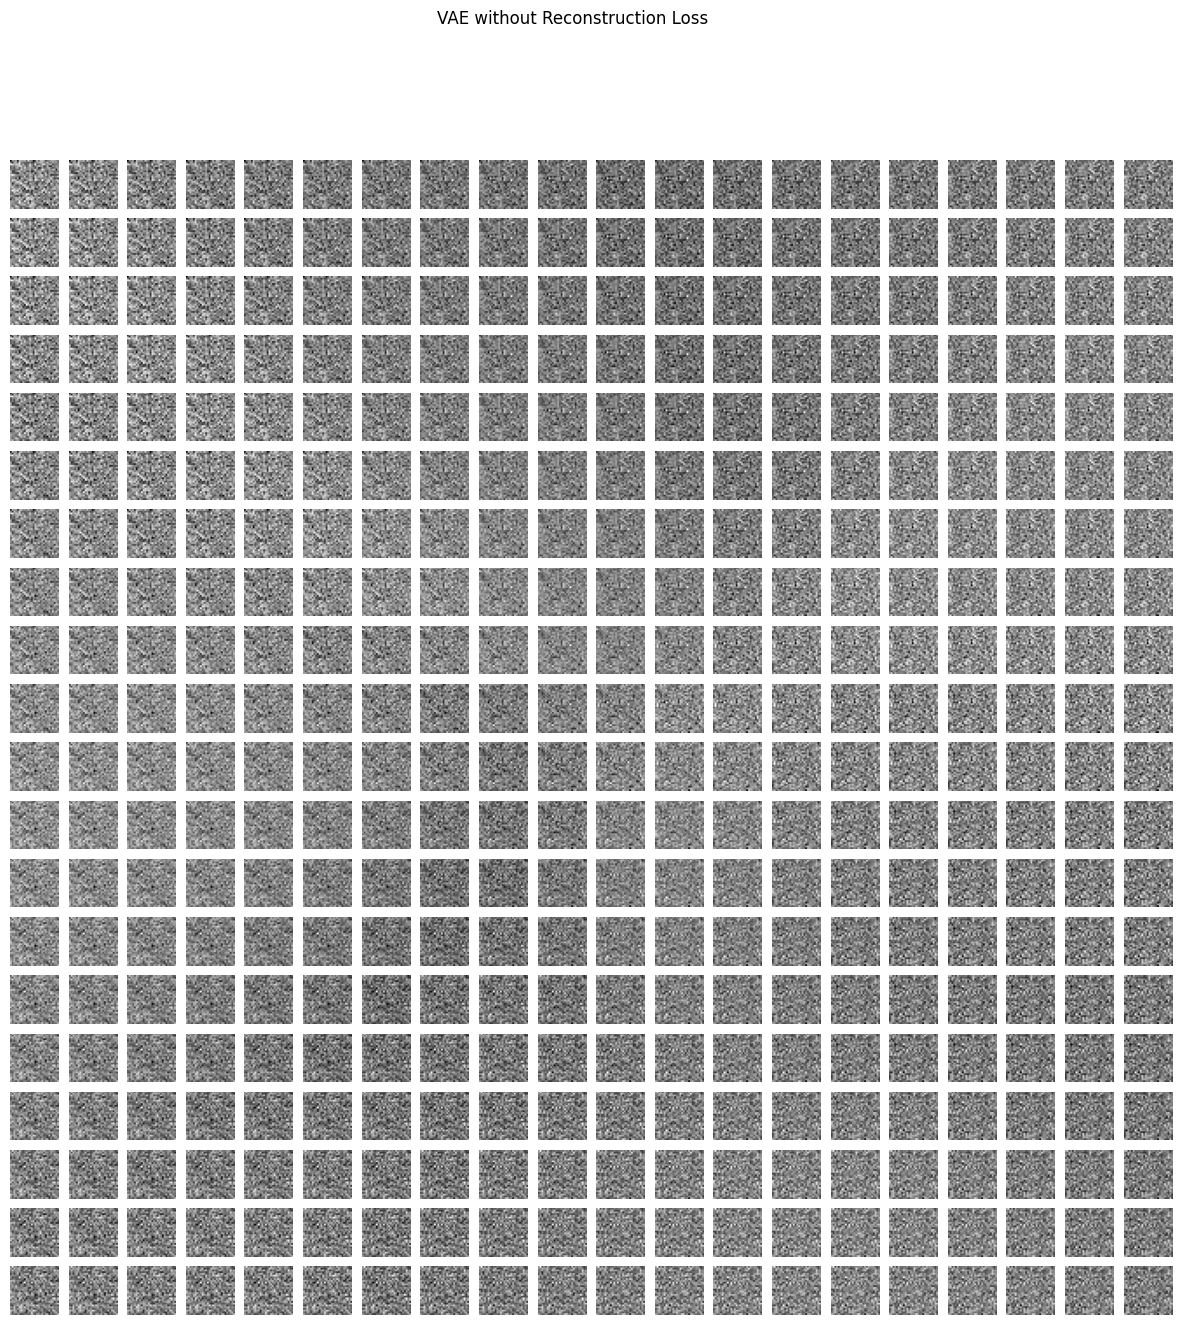

In [6]:
def experiment_no_recon_loss():
    print("\nExperiment: VAE without Reconstruction Loss (KLD only)")
    model = VAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        train_loss, train_recon, train_kld = train(model, optimizer, epoch, use_recon=False, use_kld=True)
        test_loss, test_recon, test_kld = test(model, epoch, use_recon=False, use_kld=True)
        train_losses.append((train_loss, train_recon, train_kld))
        test_losses.append((test_loss, test_recon, test_kld))

    visualize_latent_space(model, "VAE without Reconstruction Loss")
    visualize_reconstructions(model, "VAE without Reconstruction Loss")
    visualize_gaussian_grid(model, "VAE without Reconstruction Loss")
    return model

m=experiment_no_recon_loss()

- Without the reconstruction loss, the VAE fails to generate meaningful digits, producing only random noise. The model does not learn to map latent representations to meaningful outputs, highlighting the importance of reconstruction loss in guiding the decoder to generate structured images.

# 3. VAE without KL divergence loss (Reconstruction only)


Experiment: VAE without KL Divergence Loss (Reconstruction only)
====> Epoch: 1 Average loss: 175.9725 = Recon: 175.9725 + KLD: 0.0000
====> Test set loss: 154.7102 = Recon: 154.7102 + KLD: 0.0000
====> Epoch: 2 Average loss: 151.3693 = Recon: 151.3693 + KLD: 0.0000
====> Test set loss: 148.0603 = Recon: 148.0603 + KLD: 0.0000
====> Epoch: 3 Average loss: 145.9025 = Recon: 145.9025 + KLD: 0.0000
====> Test set loss: 144.3038 = Recon: 144.3038 + KLD: 0.0000
====> Epoch: 4 Average loss: 142.5452 = Recon: 142.5452 + KLD: 0.0000
====> Test set loss: 141.3864 = Recon: 141.3864 + KLD: 0.0000
====> Epoch: 5 Average loss: 140.1024 = Recon: 140.1024 + KLD: 0.0000
====> Test set loss: 139.6002 = Recon: 139.6002 + KLD: 0.0000
====> Epoch: 6 Average loss: 138.1067 = Recon: 138.1067 + KLD: 0.0000
====> Test set loss: 137.5790 = Recon: 137.5790 + KLD: 0.0000
====> Epoch: 7 Average loss: 136.7663 = Recon: 136.7663 + KLD: 0.0000
====> Test set loss: 136.8355 = Recon: 136.8355 + KLD: 0.0000
====> Epoc

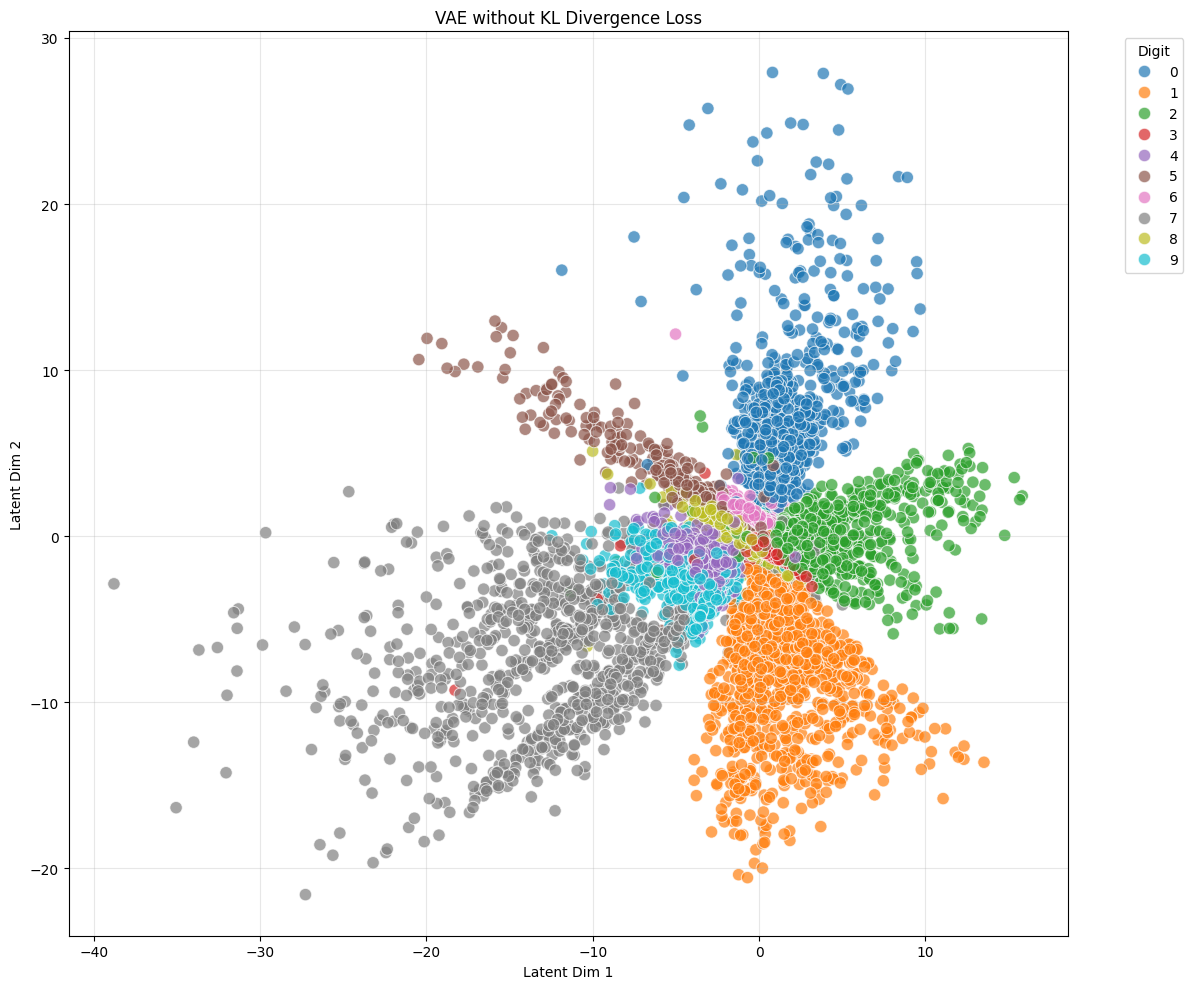

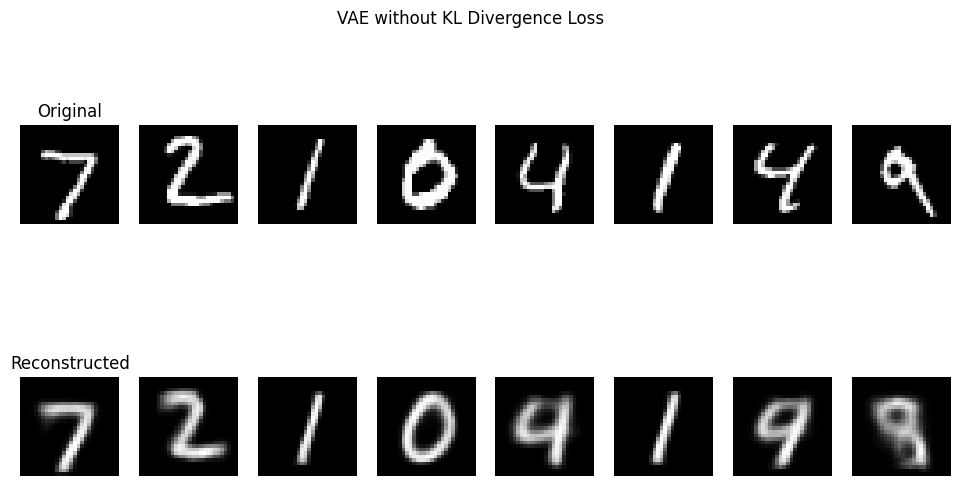

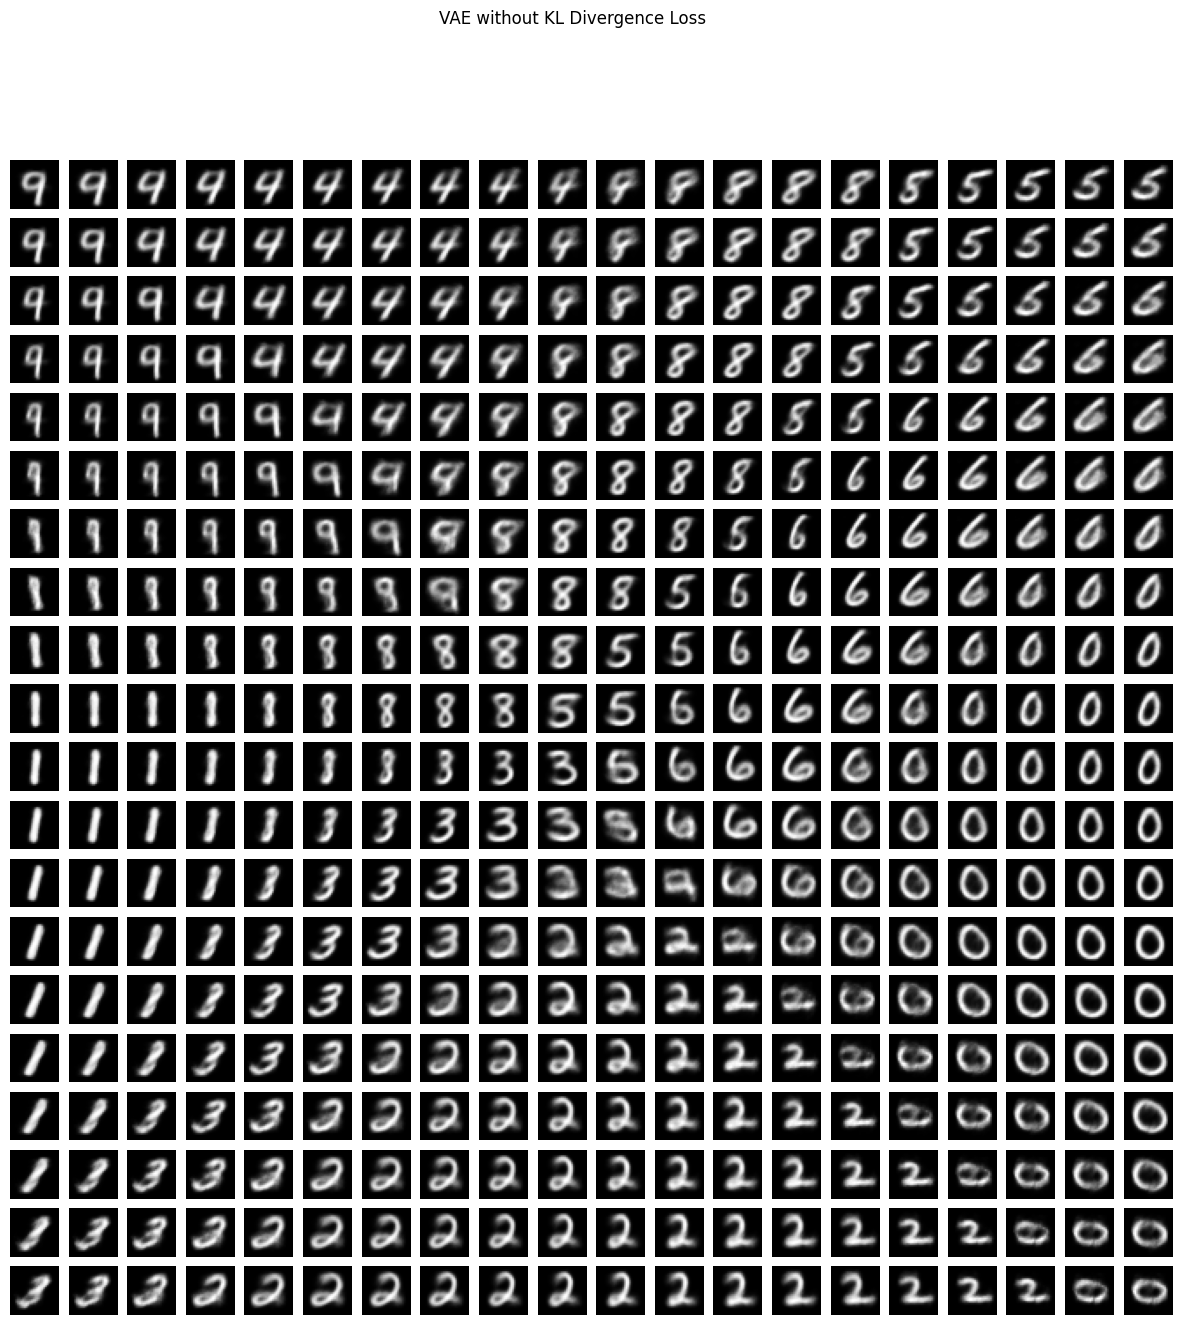

In [7]:
def experiment_no_kld_loss():
    print("\nExperiment: VAE without KL Divergence Loss (Reconstruction only)")
    model = VAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        train_loss, train_recon, train_kld = train(model, optimizer, epoch, use_recon=True, use_kld=False)
        test_loss, test_recon, test_kld = test(model, epoch, use_recon=True, use_kld=False)
        train_losses.append((train_loss, train_recon, train_kld))
        test_losses.append((test_loss, test_recon, test_kld))

    visualize_latent_space(model, "VAE without KL Divergence Loss")
    visualize_reconstructions(model, "VAE without KL Divergence Loss")
    visualize_gaussian_grid(model, "VAE without KL Divergence Loss")
    return model

m=experiment_no_kld_loss()

- Without the KL divergence loss, the VAE lacks regularization in its latent space, leading to highly clustered and non-smooth transitions between digits. The model tends to memorize specific samples rather than learning a well-structured latent representation, reducing the ability to generate diverse and meaningful variations of digits.

# 4. VAE with MSE instead of BCE


Experiment: VAE with MSE Loss
====> Epoch: 1 Average loss: 48.1418 = Recon: 45.8805 + KLD: 2.2613
====> Test set loss: 41.7689 = Recon: 38.3690 + KLD: 3.3999
====> Epoch: 2 Average loss: 40.9008 = Recon: 37.2515 + KLD: 3.6493
====> Test set loss: 39.8390 = Recon: 35.8471 + KLD: 3.9919
====> Epoch: 3 Average loss: 39.2449 = Recon: 35.1636 + KLD: 4.0813
====> Test set loss: 38.6198 = Recon: 34.2494 + KLD: 4.3705
====> Epoch: 4 Average loss: 38.0675 = Recon: 33.6793 + KLD: 4.3883
====> Test set loss: 37.4743 = Recon: 32.8102 + KLD: 4.6641
====> Epoch: 5 Average loss: 37.2844 = Recon: 32.7118 + KLD: 4.5725
====> Test set loss: 37.0336 = Recon: 32.3237 + KLD: 4.7099
====> Epoch: 6 Average loss: 36.7522 = Recon: 32.0396 + KLD: 4.7127
====> Test set loss: 36.6493 = Recon: 31.8758 + KLD: 4.7735
====> Epoch: 7 Average loss: 36.3404 = Recon: 31.5253 + KLD: 4.8151
====> Test set loss: 36.5453 = Recon: 31.6721 + KLD: 4.8732
====> Epoch: 8 Average loss: 36.0151 = Recon: 31.1246 + KLD: 4.8905
====>

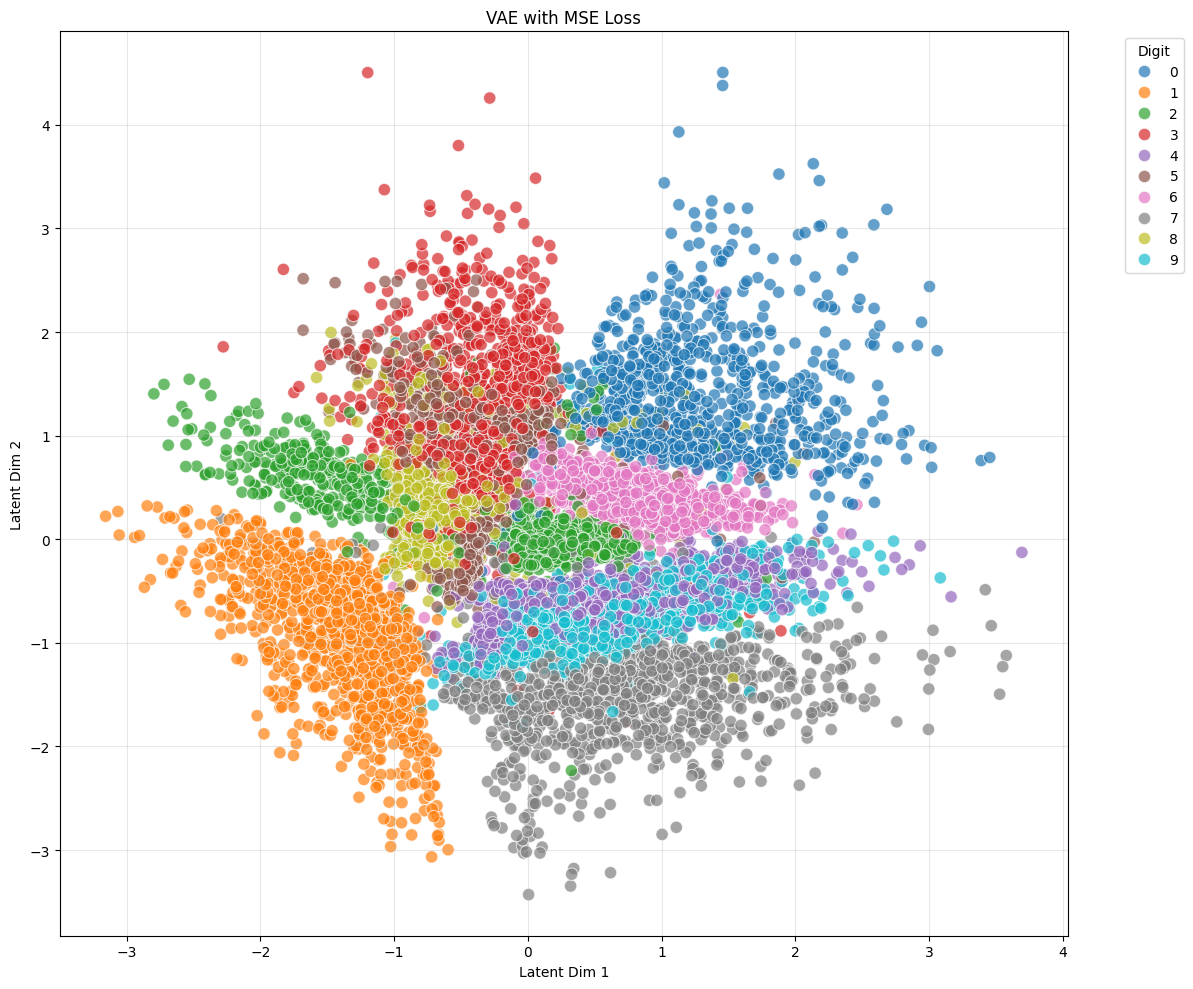

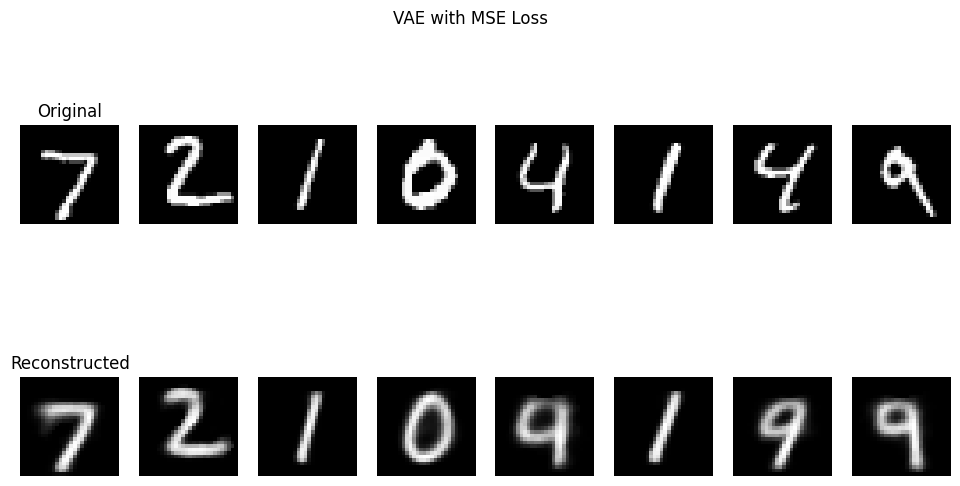

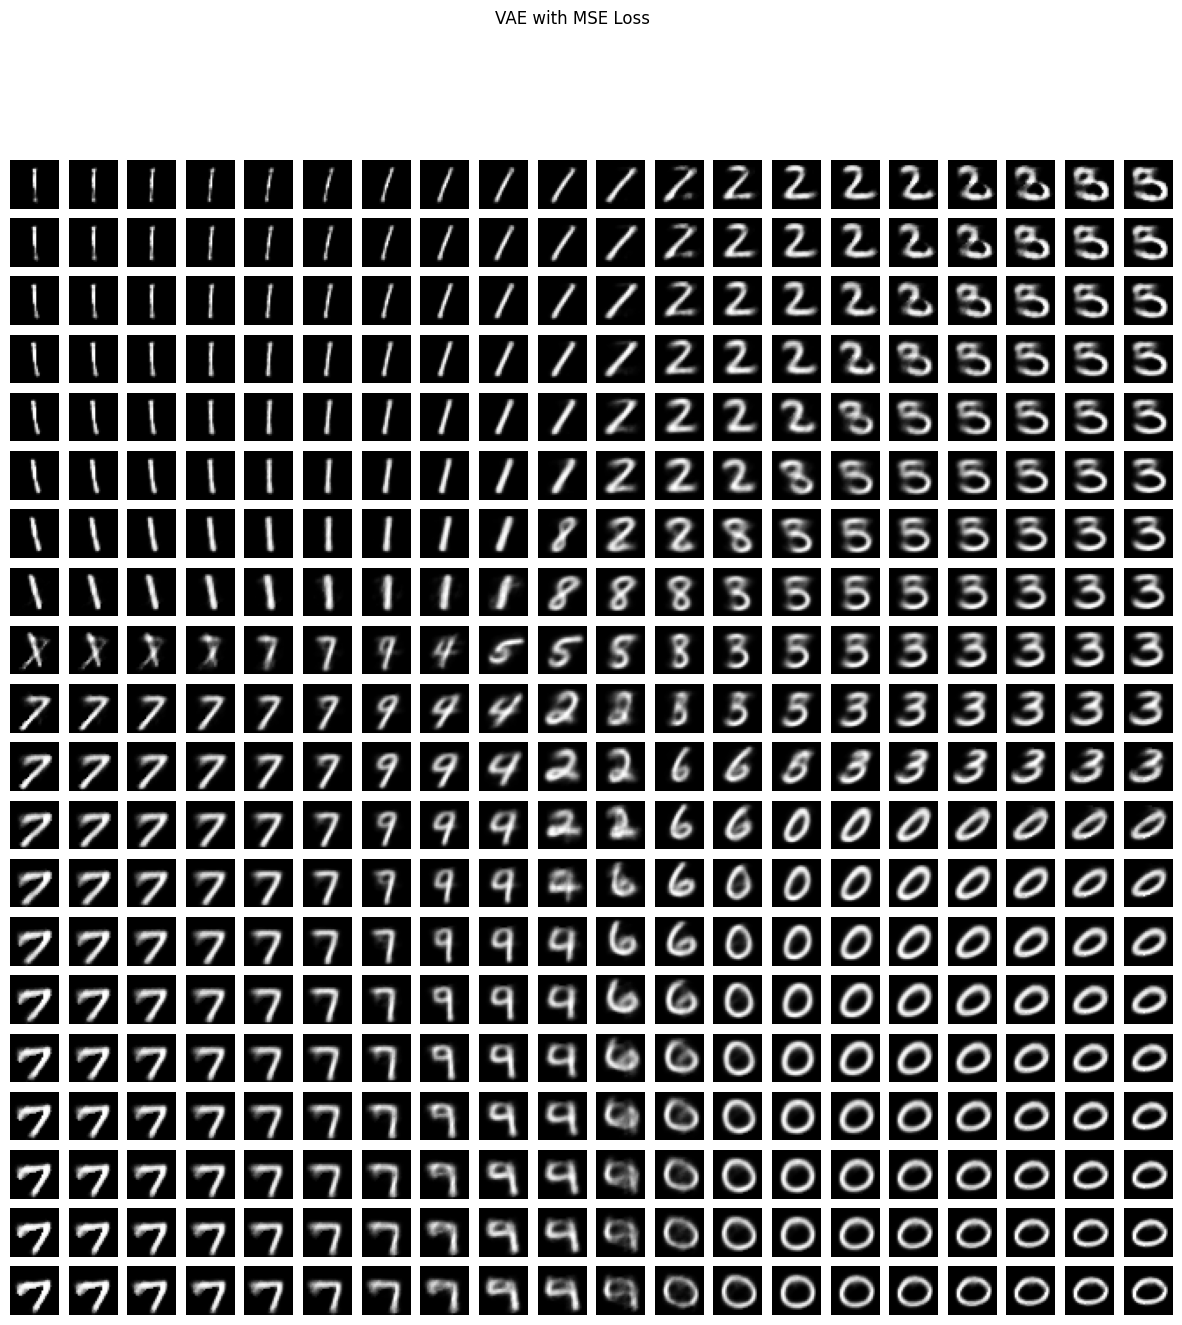

In [8]:
def experiment_mse_loss():
    print("\nExperiment: VAE with MSE Loss")
    model = VAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        train_loss, train_recon, train_kld = train(model, optimizer, epoch, use_recon=True, use_kld=True, use_mse=True)
        test_loss, test_recon, test_kld = test(model, epoch, use_recon=True, use_kld=True, use_mse=True)
        train_losses.append((train_loss, train_recon, train_kld))
        test_losses.append((test_loss, test_recon, test_kld))

    visualize_latent_space(model, "VAE with MSE Loss")
    visualize_reconstructions(model, "VAE with MSE Loss")
    visualize_gaussian_grid(model, "VAE with MSE Loss")
    return model

m=experiment_mse_loss()

- With Mean Squared Error (MSE) loss, the VAE generates blurry images due to its tendency to penalize high-intensity differences, averaging pixel values instead of preserving sharp details. The transitions between digits appear less smooth, and some regions of the latent space are not well-utilized, leading to mode collapse where certain digits dominate.